# Code-along 2024-04-16 Full Stack Data Engineering with Python

Some background context briefly summarizing
- We will deal with HDF5 files
- The data will come from the LIGO Detector
- Manipulate HDF5 with Python, extract and manipulate data make it ready for scientific analysis.
- We are closer to science and exploration of the Universe then we believe. This data is open and available to us, and can be used for a variety of proposes.


## Task 0: Setup

For this analysis we need the some Python packages in order to read, apply calculations and filters over our data.

### Instructions

Import the following packages.

- Import `numpy` using the alias `pd`.
- From the `scipy` package, import `signal`, `interpolate.interp1d` and  `butter, filtfilt`.
- Use `matplotlib` on `pyplot` and `mlab`.
- Don't forget the `h5py` library that will help on the dicovery of the HDF5 file.

In [1]:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py as h5

## Task 1: Import the LIGO data

In [2]:
l1 = h5.File('L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'r')
h1 = h5.File('H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'r')

We can see the keys, which are the name of the groups.

The 'strain' group contains the time series.

The file contains the following groups:

In [3]:
l1.keys()

<KeysViewHDF5 ['meta', 'quality', 'strain']>

To access the groups you pass the name of it inside brackets, the same as you do with a dictionary.

In [4]:
l1['strain'].keys()

<KeysViewHDF5 ['Strain']>

In [5]:
l1['strain']['Strain']

<HDF5 dataset "Strain": shape (131072,), type "<f8">

If we get into a dataset with a valuable shape we can access it as it is a numpy array

In [6]:
l1['strain']['Strain'][:]

array([-1.00432555e-18, -9.58114996e-19, -9.03059379e-19, ...,
       -1.10862808e-18, -1.13349772e-18, -1.12487097e-18])

### Set the time series into variables

In [7]:
strain_L1 = l1['strain']['Strain'][:]
strain_H1 = h1['strain']['Strain'][:]

Note the type of the data `extracted`

In [8]:
type(strain_L1), strain_L1.shape

(numpy.ndarray, (131072,))

### A dataset can also contain attributes. It can be accessed as below:

In [9]:
l1_strin_attrs = l1['strain']['Strain'].attrs.keys()

for att in l1_strin_attrs:
    print(str(att) + ":", l1['strain']['Strain'].attrs[att])

Npoints: 131072
Xlabel: GPS time
Xspacing: 0.000244140625
Xstart: 1126259447
Xunits: second
Ylabel: Strain
Yunits: 


## Task 1: Organizing the time to start the plot and calculations

Since we do not have the time inside our file, we will calculate it using the avaliable informations:
1. We know that the data we have is a collection of 23 seconds, with the 4KHz frequency. What means that every second contains 4096 data points.
2. The GPS time is stored in ['strain']['Strain'].attrs['Xstart']
3. If we add 32 seconds we have the end time of the phenomenon
4. Additionally, we can use Xspacing (['strain']['Strain'].attrs['Xspacing']), which is the time interval, and have the time interval of each point collected, so using np.arange we can create an array that is equivalent to time.

In [10]:
Xstart_time = l1['strain']['Strain'].attrs['Xstart']
Xend_time = Xstart_time + 32
Xspacing_time =  l1['strain']['Strain'].attrs['Xspacing']

time = np.arange(Xstart_time, Xend_time, Xspacing_time)

According to the information we have previously, the phenomenon lasts for a total of 0.5 seconds, and it accures exacly at Sep 14 09:50:45 GMT 2015. Which is **1126259462.443** .

In [11]:
mid = np.where(time >= 1126259462.443)[0][0]
mid

63255

## Task 2: First look at the signal

Let's look at it two seconds before and two second after the start of the funsion.

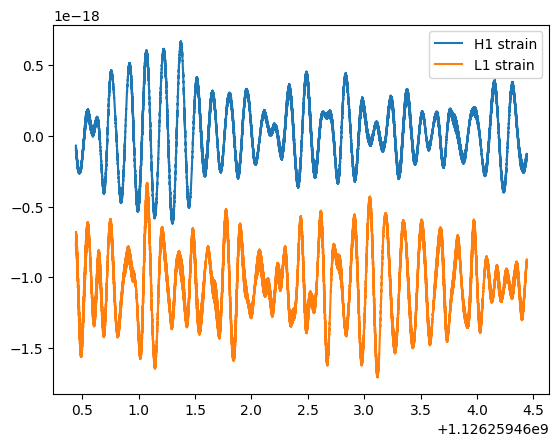

In [12]:
# Calculate 2 seconds plus and less
start_time_vis = mid - 2*4096
end_time_vis = mid + 2*4096

# Plot both time series
plt.plot(time[start_time_vis:end_time_vis], strain_H1[start_time_vis:end_time_vis], label='H1 strain')
plt.plot(time[start_time_vis:end_time_vis], strain_L1[start_time_vis:end_time_vis], label='L1 strain')
plt.legend(loc='best')
plt.show()

Unfortunately, it is not possible to visualize the waveform without any treatment on the waveform.

## Task 2: Applying filters

The following steps:
1. Whitening: evens out the noise so that it looks the same everywhere, making it easier to spot important signals. By dividing the data by the "noise amplitude spectrum," which measures noise at different frequencies, noisy parts are toned down, especially at low and high frequencies. In astrophysics, whitening is crucial because it lets us concentrate on significant data without prior knowledge of noise sources. Plus, after whitening, data is measured in "sigmas," indicating how far each point is from the average.
2. Filter low and high freqeuncy with bandpassing.


Bellow we have the following methods to be used:

In [13]:
fs = 4096

def whiten(strain, dt):
    NFFT = 1*fs
    fmin = 10
    fmax = 2000 
    Pxx, freqs = mlab.psd(strain, Fs = fs, NFFT = NFFT)
    psd = interp1d(freqs, Pxx)
    
    Nt = len(strain)   
    freqs_w = np.fft.rfftfreq(Nt, dt)
    
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(psd(freqs_w) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)    

    return white_ht

def bandpassing(strain_whiten, is_L1=False):
    bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
    strain_whitenbp = filtfilt(bb, ab, strain_whiten)
    if is_L1:
        # the distance in time betweeen the labs
        strain_whitenbp = -np.roll(strain_whitenbp,int(0.007*4096))
    return strain_whitenbp

<details>
  <summary>Hints</summary> 
  <p>
      
- Use the `whiten()` function pass the strain and Xspacing_time as dt.
- Get the result and apply the `bandpassing` method.
      
  </p>
</details>

In [14]:
strain_H1_whiten = whiten(strain_H1, Xspacing_time)
strain_L1_whiten = whiten(strain_L1, Xspacing_time)

strain_H1_whitenbp = bandpassing(strain_H1_whiten)
strain_L1_whitenbp = bandpassing(strain_L1_whiten, True)

## Task 3: Plot the final waveform

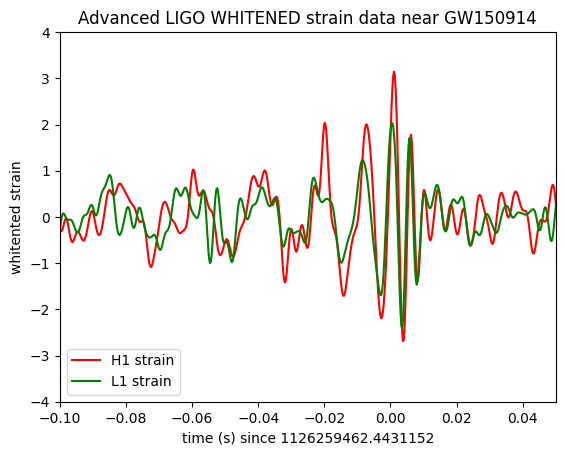

In [15]:
plt.figure()
plt.plot(time-1126259462.422, strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-1126259462.422, strain_L1_whitenbp,'g',label='L1 strain')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(time[mid]))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
plt.savefig('GW150914_strain_whitened.png')

In [16]:
l1.close()
h1.close()

# Store data on hdf5 files


Let's open the L1 file again using the tag 'a', which will allow you to write or read also.
Now it is only necessary to create a **dataset:**

In [17]:
l1_copy = h5.File('L-L1_GWOSC_4KHZ_R1-1126259447-32_copy.hdf5', 'a')

In [18]:
l1_copy['strain'].create_dataset('Strain_whitebp', data=strain_L1_whitenbp)

<HDF5 dataset "Strain_whitebp": shape (131072,), type "<f8">

#### We can see that we do no have to close the file or use any 'save' method, the file is aready update.

In [19]:
x = h5.File('L-L1_GWOSC_4KHZ_R1-1126259447-32_copy.hdf5', 'a')
x['strain']['Strain_whitebp'][()] == strain_L1_whitenbp

array([ True,  True,  True, ...,  True,  True,  True])

## Creating a HDF5 file()

In [20]:
h5.File('test_file.h5', 'a')

<HDF5 file "test_file.h5" (mode r+)>